## Exercício
Um dataset sintético contendo alguns exemplos de diferentes formas básicas é criado. Em seguida, crie um dataset e um modelo convolucional que classifique o formato na imagem.

In [30]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [31]:
# Parâmetros
image_size = 64
num_examples = 2000
num_classes = 5
output_file = "data/synthetic.csv"

In [32]:
# Função para gerar uma imagem de uma determinada classe
def generate_image(label):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    if label == 0:
        # Classe 0: Círculos
        center = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        radius = np.random.randint(5, 10)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.circle(image, center, radius, color, -1)
    elif label == 1:
        # Classe 1: Triângulos equiláteros
        side_length = np.random.randint(10, 20)
        height = int(np.sqrt(3)/2 * side_length)
        center = (np.random.randint(side_length//2, image_size-side_length//2),
                  np.random.randint(height//2, image_size-height//2))
        pts = np.array([[center[0], center[1] - 2*height//3],
                        [center[0] - side_length//2, center[1] + height//3],
                        [center[0] + side_length//2, center[1] + height//3]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.fillPoly(image, [pts], color)
    elif label == 2:
        # Classe 2: Linhas Horizontais
        y = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (0, y), (image_size, y), color, thickness)
    elif label == 3:
        # Classe 3: Quadrados
        top_left = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        size = np.random.randint(5, 10)
        bottom_right = (top_left[0] + size, top_left[1] + size)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.rectangle(image, top_left, bottom_right, color, -1)
    elif label == 4:
        # Classe 4: Linhas Verticais
        x = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (x, 0), (x, image_size), color, thickness)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [33]:
def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

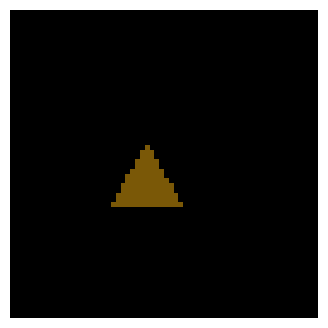

In [34]:
show_image(generate_image(1))

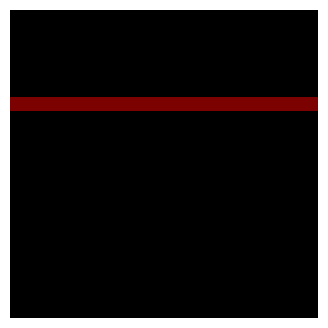

In [50]:
show_image(generate_image(2))

In [ ]:
show_image(generate_image(4))

In [35]:
!mkdir -p data

In [36]:
data = []
labels = []
for _ in tqdm(range(num_examples)):
    label = np.random.randint(0, num_classes)
    image = generate_image(label).flatten()
    data.append(np.concatenate(([label], image)))
    labels.append(label)

data = np.array(data)

# Salvando em CSV
df = pd.DataFrame(data)
df.to_csv(output_file, index=False, header=False)

print(f"Dataset salvo em {output_file}")

100%|██████████| 2000/2000 [00:00<00:00, 12834.74it/s]


Dataset salvo em data/synthetic.csv


## Agora é com você!

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [38]:
# Definindo a classe SyntheticCSVLoader para carregar o dataset a partir de um arquivo CSV
class SyntheticCSVLoader(Dataset):
    def __init__(self, csv_file, image_size=64, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]

        # As demais colunas são os pixels da imagem (64x64x3)
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(self.image_size, self.image_size, 3)

        # Converte a imagem para tensor e ajusta os eixos para o formato (C, H, W)
        image = torch.tensor(image).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, label


In [39]:
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

synthetic_dataset = SyntheticCSVLoader(
    csv_file="data/synthetic.csv",
    transform=transform
)

In [40]:
# Dividindo o dataset em conjuntos de treino e teste
train_size = int(0.8 * len(synthetic_dataset))
test_size = len(synthetic_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(synthetic_dataset, [train_size, test_size])


In [41]:
# Criando DataLoaders para os subsets
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [42]:
# Definindo o modelo CNN aprimorado
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # Aumentando os filtros para 32
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)  # Aumentando os filtros para 64
        self.fc1 = nn.Linear(64 * 13 * 13, 256)  # Aumentando os neurônios para 256
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)  # Adicionando dropout

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 13 * 13)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [43]:
# Função para treinar o modelo
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=10):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(trainloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history

In [44]:
# Função para plotar a história do treinamento
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


In [45]:
# Função para testar o modelo
def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


In [46]:
# Inicializando o modelo aprimorado, a função de perda e o otimizador
model = ImprovedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Usando Adam para melhor convergência


In [47]:
# Treinamento do modelo
num_epochs = 10
history = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=num_epochs)


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


Epoch 1, Train Loss: 1.571, Train Accuracy: 31.56%, Val Loss: 1.300, Val Accuracy: 58.75%


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Epoch 2, Train Loss: 0.937, Train Accuracy: 64.50%, Val Loss: 0.653, Val Accuracy: 70.00%


100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


Epoch 3, Train Loss: 0.609, Train Accuracy: 73.88%, Val Loss: 0.530, Val Accuracy: 74.75%


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Epoch 4, Train Loss: 0.495, Train Accuracy: 78.94%, Val Loss: 0.442, Val Accuracy: 79.50%


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Epoch 5, Train Loss: 0.388, Train Accuracy: 84.94%, Val Loss: 0.368, Val Accuracy: 88.00%


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


Epoch 6, Train Loss: 0.270, Train Accuracy: 90.94%, Val Loss: 0.241, Val Accuracy: 89.75%


100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


Epoch 7, Train Loss: 0.158, Train Accuracy: 95.00%, Val Loss: 0.181, Val Accuracy: 93.75%


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Epoch 8, Train Loss: 0.133, Train Accuracy: 96.00%, Val Loss: 0.161, Val Accuracy: 94.00%


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


Epoch 9, Train Loss: 0.112, Train Accuracy: 96.69%, Val Loss: 0.137, Val Accuracy: 94.25%


100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


Epoch 10, Train Loss: 0.084, Train Accuracy: 97.69%, Val Loss: 0.124, Val Accuracy: 94.50%
Treinamento concluído


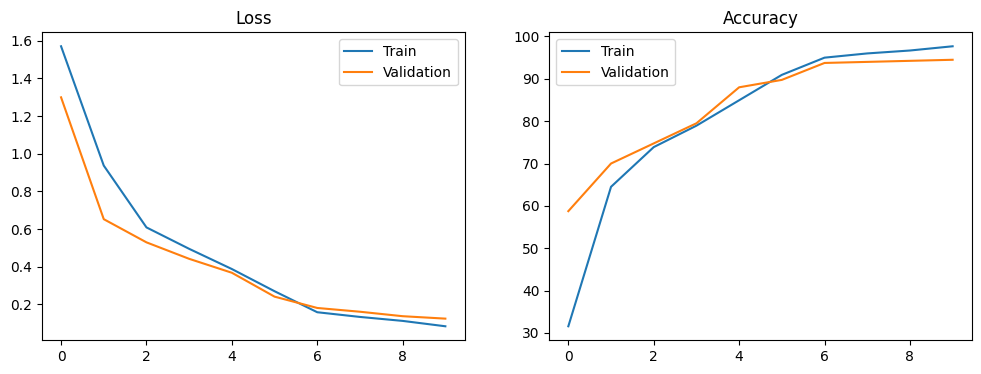

In [48]:
# Plotando a história do treinamento
plot_history(history)


In [49]:
# Teste do modelo no conjunto de teste
test_model(model, testloader)


Acurácia da rede na base de teste: 94.50%


## **Explicação das Melhorias:**

  **Arquitetura da Rede:** Aumentei o número de filtros nas camadas convolucionais para 32 e 64, e o número de neurônios na camada fully connected para 256, o que permite que a rede capture mais detalhes nas imagens.

  **Dropout:** Adicionei um dropout de 50% após a camada fully connected para ajudar a reduzir o overfitting.

  **Otimização:** Troquei o otimizador para Adam, que geralmente converge mais rápido e pode lidar melhor com problemas de instabilidade na taxa de aprendizado.

  **Taxa de Aprendizado:** A taxa de aprendizado foi mantida em 0.001, adequada para Adam.